In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

2024-06-10 19:50:36.380532: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Daten einlesen lokal LP
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
kiwo_df = pd.read_csv('kiwo.csv')
wetter_df = pd.read_csv('wetter.csv')

# Convert date columns to datetime format
train_df['Datum'] = pd.to_datetime(train_df['Datum'])
test_df['Datum'] = pd.to_datetime(test_df['Datum'])
wetter_df['Datum'] = pd.to_datetime(wetter_df['Datum'])
kiwo_df['Datum'] = pd.to_datetime(kiwo_df['Datum'])

In [3]:
# Merge the datasets
train_df = pd.merge(train_df, wetter_df, on='Datum', how='left')
test_df = pd.merge(test_df, wetter_df, on='Datum', how='left')

train_df = pd.merge(train_df, kiwo_df, on='Datum', how='left')
test_df = pd.merge(test_df, kiwo_df, on='Datum', how='left')

train_df['KielerWoche'] = train_df['KielerWoche'].fillna(0)
test_df['KielerWoche'] = test_df['KielerWoche'].fillna(0)

In [4]:
# Handle missing values in weather-related columns
train_df['Bewoelkung'] = train_df['Bewoelkung'].fillna(train_df['Bewoelkung'].mean())
train_df['Temperatur'] = train_df['Temperatur'].fillna(train_df['Temperatur'].mean())
train_df['Windgeschwindigkeit'] = train_df['Windgeschwindigkeit'].fillna(train_df['Windgeschwindigkeit'].mean())
train_df['Wettercode'] = train_df['Wettercode'].fillna(train_df['Wettercode'].mode()[0])

test_df['Bewoelkung'] = test_df['Bewoelkung'].fillna(test_df['Bewoelkung'].mean())
test_df['Temperatur'] = test_df['Temperatur'].fillna(test_df['Temperatur'].mean())
test_df['Windgeschwindigkeit'] = test_df['Windgeschwindigkeit'].fillna(test_df['Windgeschwindigkeit'].mean())
test_df['Wettercode'] = test_df['Wettercode'].fillna(test_df['Wettercode'].mode()[0])

In [5]:
# Feature engineering: Extract additional features from the date column
def extract_date_features(df):
    df['Year'] = df['Datum'].dt.year
    df['Month'] = df['Datum'].dt.month
    df['Day'] = df['Datum'].dt.day
    df['DayOfWeek'] = df['Datum'].dt.dayofweek
    df['WeekOfYear'] = df['Datum'].dt.isocalendar().week
    df['Quarter'] = df['Datum'].dt.quarter
    return df

train_df = extract_date_features(train_df)
test_df = extract_date_features(test_df)

In [6]:
# Define features and target variable
features = ['Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode', 
            'KielerWoche', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'Warengruppe']
target = 'Umsatz'

X = train_df[features]
y = train_df[target]

In [7]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(test_df[features])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Build the neural network model using TensorFlow
model = Sequential([
    Dense(128, input_dim=X_train.shape[1]),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    BatchNormalization(),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1)
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,481 (48.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [11]:


model.compile(loss="mse", optimizer=Adam (learning_rate=0.001))

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=90, batch_size=32)



Epoch 1/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 63511.2070 - val_loss: 55023.3242
Epoch 2/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 62215.4609 - val_loss: 51157.6094
Epoch 3/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 52959.9023 - val_loss: 43395.6211
Epoch 4/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 42862.2344 - val_loss: 27849.2422
Epoch 5/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 30225.9590 - val_loss: 18201.4434
Epoch 6/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22217.1895 - val_loss: 12225.2188
Epoch 7/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15315.9043 - val_loss: 7247.0166
Epoch 8/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11379.5537 - val_loss: 4992.3423
Epoch 9/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7416.5132 - val_loss: 3524.5530
Epoch 10/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9670.8281 - val_loss: 2718.4722
Epoch 11/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6375

In [12]:
# Evaluate the model
y_pred = model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, y_pred)
print(f'TensorFlow Neural Network MAPE: {mape}')

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TensorFlow Neural Network MAPE: 0.20236131399716858


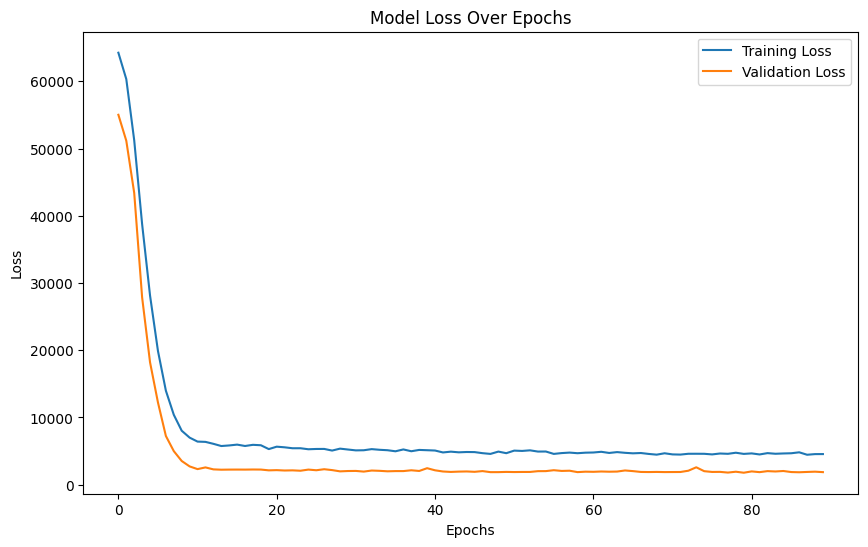

In [13]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
# Make predictions on the test set
test_predictions = model.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [15]:
# Prepare the submission file
submission_df = test_df[['id']].copy()
submission_df['umsatz'] = test_predictions
submission_df.to_csv('Tensorflow_v5_leaky_relu.csv', index=False)